In [1]:
from brian2 import *
import brian2.numpy_ as np
prefs.codegen.target = 'numpy'

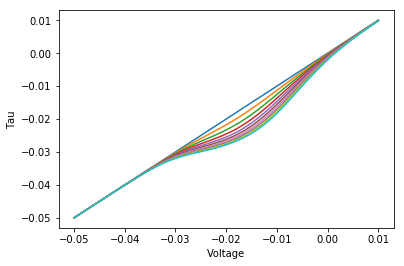

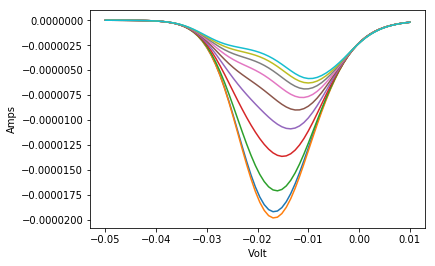

In [2]:
start_scope()
#Implementing the independent Na current.

duration = 100*ms
#Parameters
C = 1*ufarad
VNa = 55*mV
gNamax = 0.04*siemens
vhalfs = -60*mV
a0s = 0.0003/ms
zetas = 12/mV
gms = 0.2
q10 = 2
temp = 34
Ra = 0.4/ms
Rb = 0.124/ms
Rg = 0.01/ms
Rd = 0.03/ms
tha = -30*mV
qa = 7.2*mV
qd = qg = 1.5*mV
sh = 24*mV
thinf = -50*mV
qinf = 4*mV
thi1 = -45*mV
smax = 10*ms
vvh = -58*mV
vvs = 2*mV
qt = (q10**((temp - 24)/10))/mV

@check_units(V=volt, th=volt, a=Hz, q=volt, result=Hz*volt)
def trap0(V, th, a, q):
    if (abs(V-thi1) > 10**-6*mV):
        return a * (V - th) / (1 - exp(-(V - th)/q))
    else:
        return a * q

eqs = Equations('''
                    dV/dt = (INa + I)/C : volt
                    INa = gNa*(V - VNa) : amp
                    gNa = gNamax*mNa*mNa*mNa*hNa*sNa : siemens
                    dmNa/dt = (infmNa - mNa)/taum : 1
                    dhNa/dt = (infhNa - hNa)/tauh : 1
                    dsNa/dt = (infsNa - sNa)/taus : 1
                    infmNa = a1/(a1 + b1) : 1 
                    infhNa = 1/(1 + exp((V-thinf-sh)/qinf)) : 1
                    infsNa = alpv+(1-alpv) : 1
                    taum = 1/(a1 + b1)/qt : second 
                    tauh =  1/(a2 + b2)/qt : second 
                    taus = bets/(a0s*(1 + alps)) : second
                    alps = exp(0.001*zetas*(V-vhalfs-sh)*96480/(8.315*(273.16 + temp))) : 1
                    alpv = 1/(1+exp((V-vvh-sh)/vvs)) : 1
                    bets = exp(0.001*zetas*gms*(V-vhalfs-sh)*96480/(8.315*(273.16 + temp))) : 1
                    a1 = trap0(V,tha+sh,Ra,qa) : Hz*volt (constant over dt)
                    b1 = trap0(-V,-tha-sh,Rb,qa) : Hz*volt (constant over dt)
                    a2 = trap0(V,tha+sh,Rd,qd) : Hz*volt (constant over dt)
                    b2 = trap0(-V,-tha-sh,Rg,qg) : Hz*volt (constant over dt)
                    I : amp
                    ''')

group = NeuronGroup(1, eqs, threshold='V > -40*mV', refractory='V > -40*mV', method='rk2')

M = StateMonitor(group, variables=True, record=True)

store()
# Plot tau and the channel current for different voltages
voltages = np.linspace(-50, 10, 70) * mV
vs = []
Is = []
for volt in voltages:
    # Restore the original state of the network
    restore()
    alpv0 = 1/(1+exp((volt-vvh-sh)/vvs))
    group.mNa = trap0(volt,tha+sh,Ra,qa)/(trap0(volt,tha+sh,Ra,qa) + trap0(-volt,-tha-sh,Rb,qa))
    group.hNa = 1/(1 + exp((volt-thinf-sh)/qinf))
    group.sNa = alpv0+(1-alpv0)
    group.V = volt
    # Run it with the new value of tau
    run(1 * ms)
    vs.append(M.V[0])
    Is.append(M.INa[0])

figure(1)
plot(voltages, vs)
xlabel('Voltage')
ylabel('Tau');

figure(2)
plot(voltages, Is)
xlabel('Volt')
ylabel('Amps');
show()

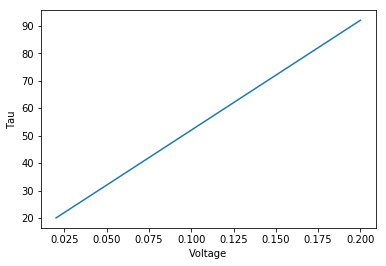

In [15]:
voltages = np.linspace(20, 200, 190)*mV
vs = []
for volt in voltages:
    vs.append(trap0(volt, tha, Ra, qa))
    
figure(1)
plot(voltages, vs)
xlabel('Voltage')
ylabel('Tau');
show()

In [4]:
print(trap0(volt, tha, Ra, qa))
print(trap0(0.00000001*mV, tha, Ra, qa))
print(Hz*volt)

412. m^2 kg s^-4 A^-1
12.1889761 m^2 kg s^-4 A^-1
Hz V
